In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import math
import json
from datetime import datetime, timedelta

# CUDA 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 1. 그리드 맵 로드
grid = np.load(r'C:/baramproject/sibal/land_sea_grid_cartopy_downsized.npy')
n_rows, n_cols = grid.shape  # 270x236

# 2. 좌표 변환 함수
def latlon_to_grid(lat, lon, lat_min=30, lat_max=38, lon_min=120, lon_max=127):
    row = int((lat_max - lat) / (lat_max - lat_min) * n_rows)
    col = int((lon - lon_min) / (lon_max - lon_min) * n_cols)
    return min(max(row, 0), n_rows-1), min(max(col, 0), n_cols-1)

# 시작점과 도착점 설정
start_lat, start_lon = 37.46036, 126.52360  # 인천항
end_lat, end_lon = 30.62828, 122.06400     # 상하이항
start_pos = latlon_to_grid(start_lat, start_lon)
end_pos = latlon_to_grid(end_lat, end_lon)

# 3. 유클리드 거리 계산 함수
def euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# 4. 조류 데이터 로드 함수
def load_tidal_data(time_str):
    file_path = f"C:/baramproject/tidal_database/tidal_{time_str}.json"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일 {file_path}가 존재하지 않습니다.")
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['result']['data']

# 5. 조류 데이터를 그리드에 매핑
def map_tidal_to_grid(tidal_data, n_rows, n_cols):
    current_grid = np.zeros((n_rows, n_cols, 2))  # [방향, 속도]
    for entry in tidal_data:
        lat = float(entry['pre_lat'])
        lon = float(entry['pre_lon'])
        row, col = latlon_to_grid(lat, lon)
        if 0 <= row < n_rows and 0 <= col < n_cols and grid[row, col] == 0:
            direction = float(entry['current_dir'])
            speed = float(entry['current_speed'])
            current_grid[row, col] = [direction, speed]
    return current_grid

# 6. 환경 클래스 정의
class NavigationEnv:
    def __init__(self, grid, start_pos, end_pos, tidal_database_path, max_steps=300, step_time_minutes=12):
        self.grid = grid
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.current_pos = start_pos
        self.actions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
        self.visit_count = {}
        self.prev_action = None
        self.tidal_database_path = tidal_database_path
        self.max_steps = max_steps  # 225 스탭
        self.step_time_minutes = step_time_minutes  # 스탭당 12분
        self.current_time = None
        self.current_tidal_data = None
        self.cumulative_time = 0  # 누적 시간 (분 단위)

    def reset(self, start_time=None):
        if start_time is None:
            start_time = self._random_start_time()
        self.current_pos = self.start_pos
        self.visit_count = {}
        self.prev_action = None
        self.current_time = start_time
        self.cumulative_time = 0
        tidal_data = load_tidal_data(self.current_time.strftime("%Y%m%d_%H%M"))
        self.current_tidal_data = map_tidal_to_grid(tidal_data, n_rows, n_cols)
        return self.get_state()

    def _random_start_time(self):
        start_datetime = datetime(2018, 1, 1, 0, 0)
        end_datetime = datetime(2018, 12, 28, 0, 0)
        total_minutes = int((end_datetime - start_datetime).total_seconds() / 60)
        random_minutes = random.randint(0, total_minutes // 30) * 30
        return start_datetime + timedelta(minutes=random_minutes)

    def get_state(self):
        prev_action_idx = self.actions.index(self.prev_action) if self.prev_action else -1
        dx = self.end_pos[0] - self.current_pos[0]
        dy = self.end_pos[1] - self.current_pos[1]
        angle_to_goal = math.atan2(dy, dx) if (dx, dy) != (0, 0) else 0
        row, col = self.current_pos
        if 0 <= row < n_rows and 0 <= col < n_cols:
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
        else:
            current_dir, current_speed = 0, 0
        return (
            self.current_pos[0], self.current_pos[1],
            prev_action_idx,
            dx, dy, angle_to_goal,
            current_dir, current_speed
        )

    def step(self, action):
        move = self.actions[action]
        new_pos = (self.current_pos[0] + move[0], self.current_pos[1] + move[1])

        if (0 <= new_pos[0] < n_rows and 0 <= new_pos[1] < n_cols and self.grid[new_pos] == 0):
            prev_dist = euclidean_distance(self.current_pos, self.end_pos)
            self.current_pos = new_pos
            new_dist = euclidean_distance(self.current_pos, self.end_pos)

            dist_change = prev_dist - new_dist
            reward = dist_change * 100 - 5  # 거리 감소 보상 및 스탭 페널티

            # 조류 보상/페널티
            row, col = self.current_pos
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
            move_angle = math.atan2(move[1], move[0])
            angle_diff = abs((current_dir - move_angle + math.pi) % (2 * math.pi) - math.pi)
            if angle_diff < math.pi / 4:
                reward += current_speed * 0.5
            elif angle_diff > 3 * math.pi / 4:
                reward -= current_speed * 0.5

            # 역방향 이동 및 반복 방문 페널티
            if dist_change < 0:
                reward -= 200
            pos_tuple = tuple(self.current_pos)
            self.visit_count[pos_tuple] = self.visit_count.get(pos_tuple, 0) + 1
            if self.visit_count[pos_tuple] > 3:
                reward -= 20 * (self.visit_count[pos_tuple] - 3)

            # 종료 조건
            if new_dist < 2:
                reward += 1000
                done = True
            else:
                done = False

            self.prev_action = move
            self.cumulative_time += self.step_time_minutes
            if self.cumulative_time >= 30:  # 30분마다 조류 데이터 갱신
                self.current_time += timedelta(minutes=30)
                tidal_data = load_tidal_data(self.current_time.strftime("%Y%m%d_%H%M"))
                self.current_tidal_data = map_tidal_to_grid(tidal_data, n_rows, n_cols)
                self.cumulative_time -= 30
        else:
            reward = -20  # 충돌 페널티
            done = False

        return self.get_state(), reward, done

# 7. 학습 설정 및 실행 (DQN 모델 및 학습 루프는 간략화)
tidal_database_path = r"C:\baramproject\tidal_database"
env = NavigationEnv(grid, start_pos, end_pos, tidal_database_path, max_steps=225, step_time_minutes=12)

# 7. DQN 모델 정의
class DQN(nn.Module):
    def __init__(self, input_dim=8, output_dim=8):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 8. SumTree 클래스 정의 (PER용)
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

# 9. PrioritizedReplayBuffer 클래스 정의 (PER용)
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.5, beta=0.6):
        self.tree = SumTree(capacity)
        self.alpha = alpha  # 우선순위 중요도
        self.beta = beta    # 샘플링 편향 보정
        self.epsilon = 0.01
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if done:
            priority = 100.0
        else:
            priority = np.max(self.tree.tree[-self.tree.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(priority, data)

    def sample(self, batch_size):
        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        sampling_probabilities = np.array(priorities) / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weights /= is_weights.max()

        return batch, idxs, torch.tensor(is_weights, dtype=torch.float32).to(device)

    def update(self, idxs, errors):
        for idx, error in zip(idxs, errors):
            p = (abs(error) + self.epsilon) ** self.alpha
            self.tree.update(idx, p)

    def __len__(self):
        return self.tree.n_entries

# 10. 학습 설정
tidal_database_path = r"C:\baramproject\tidal_database"
env = NavigationEnv(grid, start_pos, end_pos, tidal_database_path, max_steps=300)
model = DQN(8, 8).to(device)
target_model = DQN(8, 8).to(device)

# 모델 로드 또는 새로 초기화
model_path = r'C:\baramproject\trained_model\sibal11\navigation_model.pth'
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        target_model.load_state_dict(model.state_dict())
        print(f"기존 모델 '{model_path}'를 불러왔습니다. 재학습을 시작합니다.")
        epsilon = 0.5
        num_episodes = 300
    except Exception as e:
        print(f"모델 로드 실패: {e}. 새로 학습을 시작합니다.")
        target_model.load_state_dict(model.state_dict())
        epsilon = 1.0
        num_episodes = 2000
else:
    print(f"모델 파일 '{model_path}'가 없습니다. 새로 학습을 시작합니다.")
    target_model.load_state_dict(model.state_dict())
    epsilon = 1.0
    num_episodes = 20000

optimizer = optim.Adam(model.parameters(), lr=0.0005)
replay_buffer = PrioritizedReplayBuffer(20000) #capacity
batch_size = 128
gamma = 0.99
epsilon_min = 0.001
epsilon_decay = 0.9995

# 이미지 저장 디렉토리 설정
save_dir = r'C:\baramproject\trained_model\sibal11\episode_debug'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"디렉토리 '{save_dir}'를 생성했습니다.")

# 11. 학습 루프
rewards = []
path_lengths = []
progress_bar = tqdm(range(num_episodes), desc="학습 진행률")

for episode in progress_bar:
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0
    done = False
    path = [state.cpu().numpy()[:2]]  # 위치 정보만 저장
    step = 0

    while not done and step < env.max_steps:
        if random.random() < epsilon:
            action = random.randint(0, 7)
        else:
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_reward += reward
        path.append(next_state[:2])

        replay_buffer.add(state, action, reward, next_state_tensor, done)
        state = next_state_tensor

        if len(replay_buffer) >= batch_size:
            batch, idxs, is_weights = replay_buffer.sample(batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*batch)
            
            states = torch.stack(states).to(device)
            actions = torch.tensor(actions).to(device)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(device)
            next_states = torch.stack(next_states).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_model(next_states).max(1)[0]
            target = rewards_batch + gamma * next_q_values * (1 - dones)

            loss = (is_weights * nn.MSELoss(reduction='none')(q_values, target)).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            errors = torch.abs(q_values - target).detach().cpu().numpy()
            replay_buffer.update(idxs, errors)

        step += 1

    if done:
        path_length = len(path)
        path_lengths.append(path_length)
    else:
        path_lengths.append(env.max_steps)

    rewards.append(total_reward)
    progress_bar.set_postfix({'Reward': total_reward, 'Path Length': path_lengths[-1]})

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 20 == 0:
        target_model.load_state_dict(model.state_dict())

    # 중간 경로 시각화 및 이미지 저장
    if episode % 100 == 0 and episode > 0:
        print(f"Episode {episode} - 중간 경로 시각화 (Start: {start_pos}, End: {end_pos})")
        plt.figure(figsize=(10, 8))
        plt.imshow(grid, cmap='gray', origin='upper')
        path_rows = [pos[0] for pos in path]
        path_cols = [pos[1] for pos in path]
        plt.plot(path_cols, path_rows, 'r-', linewidth=2)
        plt.plot(start_pos[1], start_pos[0], 'go')
        plt.plot(end_pos[1], end_pos[0], 'bo')
        plt.title(f"Path Visualization at Episode {episode}")
        
        save_path = os.path.join(save_dir, f"episode_{episode}.png")
        plt.savefig(save_path)
        print(f"이미지 저장: {save_path}")
        plt.close()

# 12. 모델 저장
torch.save(model.state_dict(), r'C:\baramproject\trained_model\sibal11\navigation_model.pth')
print("모델이 'navigation_model.pth' 파일로 저장되었습니다.")

# 13. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Reward Graph')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(path_lengths, label='Path Length')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Learning Path Length Graph')
plt.legend()
plt.show()

# 14. 최적 경로 시각화 함수
def plot_path(path, start_pos, end_pos, grid):
    path_rows = [pos[0] for pos in path]
    path_cols = [pos[1] for pos in path]
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap='gray', origin='upper')
    plt.plot(path_cols, path_rows, 'r-', linewidth=2, label='Optimal Path')
    plt.plot(start_pos[1], start_pos[0], 'go', label=f'Start {start_pos}')
    plt.plot(end_pos[1], end_pos[0], 'bo', label=f'End {end_pos}')
    lon_ticks = np.linspace(0, n_cols, 8)
    lon_labels = np.linspace(120, 127, 8)
    plt.xticks(lon_ticks, [f"{lon:.1f}°E" for lon in lon_labels])
    lat_ticks = np.linspace(0, n_rows, 9)
    lat_labels = np.linspace(38, 30, 9)
    plt.yticks(lat_ticks, [f"{lat:.1f}°N" for lat in lat_labels])
    plt.xlabel('Longitude Grid')
    plt.ylabel('Latitude Grid')
    plt.title('Optimal Navigation Path')
    plt.legend()
    plt.grid(True)
    plt.show()

# 최적 경로 시각화
plot_path(path, start_pos, end_pos, grid)

사용 중인 디바이스: cuda
기존 모델 'C:\baramproject\trained_model\sibal11\navigation_model.pth'를 불러왔습니다. 재학습을 시작합니다.


학습 진행률:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 


=== 모델 성능 평가 결과 ===
시간: 2018-01-01 00:00:00
경로 길이: 300 스탭
조류 활용 비율: 0.00%
방향 전환 비율: 0.00%
경로 효율성: -0.30
---
시간: 2018-06-15 12:00:00
경로 길이: 300 스탭
조류 활용 비율: 0.00%
방향 전환 비율: 0.00%
경로 효율성: -0.30
---
시간: 2018-12-28 00:00:00
경로 길이: 300 스탭
조류 활용 비율: 0.00%
방향 전환 비율: 0.00%
경로 효율성: -0.30
---


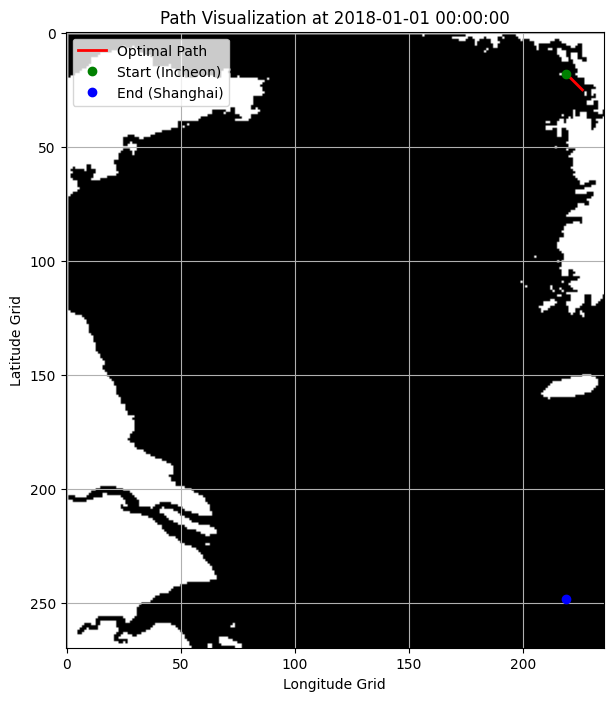

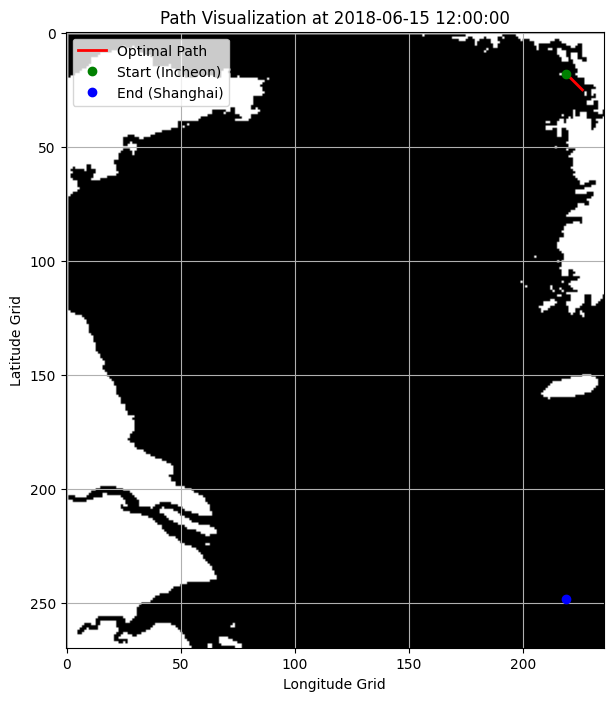

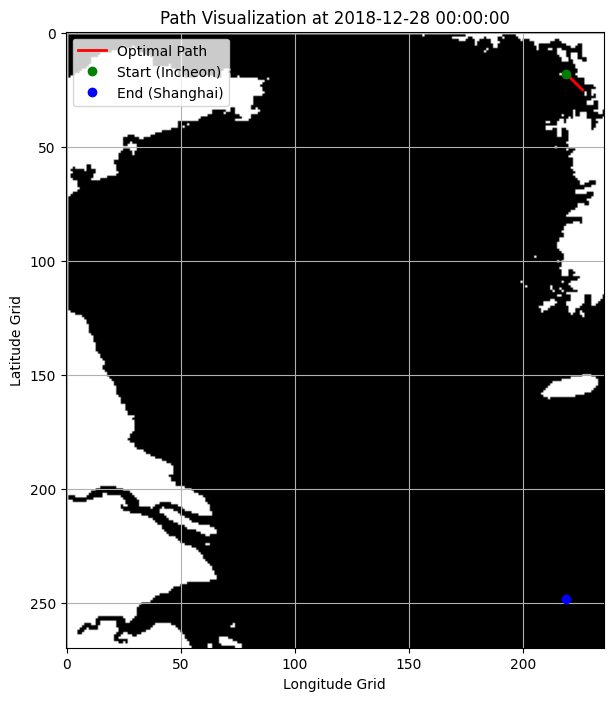

In [11]:
import numpy as np
import torch
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 1. 모델 및 환경 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid = np.load(r'C:/baramproject/sibal/land_sea_grid_cartopy_downsized.npy')
n_rows, n_cols = grid.shape

# 좌표 변환 및 유클리드 거리 함수 (기존 코드 유지)
def latlon_to_grid(lat, lon, lat_min=30, lat_max=38, lon_min=120, lon_max=127):
    row = int((lat_max - lat) / (lat_max - lat_min) * n_rows)
    col = int((lon - lon_min) / (lon_max - lon_min) * n_cols)
    return min(max(row, 0), n_rows-1), min(max(col, 0), n_cols-1)

def euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

start_lat, start_lon = 37.46036, 126.52360  # 인천항
end_lat, end_lon = 30.62828, 122.06400     # 상하이항
start_pos = latlon_to_grid(start_lat, start_lon)
end_pos = latlon_to_grid(end_lat, start_lon)

# 조류 데이터 로드 및 매핑 함수 (기존 코드 유지)
def load_tidal_data(time_str):
    file_path = f"C:/baramproject/tidal_database/tidal_{time_str}.json"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일 {file_path}가 존재하지 않습니다.")
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['result']['data']

def map_tidal_to_grid(tidal_data, n_rows, n_cols):
    current_grid = np.zeros((n_rows, n_cols, 2))
    for entry in tidal_data:
        lat = float(entry['pre_lat'])
        lon = float(entry['pre_lon'])
        row, col = latlon_to_grid(lat, lon)
        if 0 <= row < n_rows and 0 <= col < n_cols and grid[row, col] == 0:
            direction = float(entry['current_dir'])
            speed = float(entry['current_speed'])
            current_grid[row, col] = [direction, speed]
    return current_grid

# 환경 클래스
class NavigationEnv:
    def __init__(self, grid, start_pos, end_pos, tidal_data):
        self.grid = grid
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.current_pos = start_pos
        self.actions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
        self.prev_action = None
        self.current_tidal_data = tidal_data

    def reset(self):
        self.current_pos = self.start_pos
        self.prev_action = None
        return self.get_state()

    def get_state(self):
        prev_action_idx = self.actions.index(self.prev_action) if self.prev_action else -1
        dx = self.end_pos[0] - self.current_pos[0]
        dy = self.end_pos[1] - self.current_pos[1]
        angle_to_goal = math.atan2(dy, dx) if (dx, dy) != (0, 0) else 0
        row, col = self.current_pos
        if 0 <= row < n_rows and 0 <= col < n_cols:
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
        else:
            current_dir, current_speed = 0, 0
        return (
            self.current_pos[0], self.current_pos[1],
            prev_action_idx,
            dx, dy, angle_to_goal,
            current_dir, current_speed
        )

    def step(self, action):
        move = self.actions[action]
        new_pos = (self.current_pos[0] + move[0], self.current_pos[1] + move[1])

        if (0 <= new_pos[0] < n_rows and 0 <= new_pos[1] < n_cols and self.grid[new_pos] == 0):
            self.current_pos = new_pos
            new_dist = euclidean_distance(self.current_pos, self.end_pos)
            move_angle = math.atan2(move[1], move[0])
            row, col = self.current_pos
            current_dir = self.current_tidal_data[row, col, 0] * math.pi / 180
            current_speed = self.current_tidal_data[row, col, 1]
            angle_diff = abs((current_dir - move_angle + math.pi) % (2 * math.pi) - math.pi)

            if new_dist < 2:
                done = True
            else:
                done = False

            self.prev_action = move
            return self.get_state(), done
        else:
            done = False
            return self.get_state(), done

# DQN 모델 로드
class DQN(nn.Module):
    def __init__(self, input_dim=8, output_dim=8):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 모델 테스트 및 지표 계산
model = DQN(8, 8).to(device)
model_path = r'C:\baramproject\trained_model\sibal11\navigation_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# 여러 시간대 테스트
test_times = [
    datetime(2018, 1, 1, 0, 0),  # 1월 1일 00:00
    datetime(2018, 6, 15, 12, 0),  # 6월 15일 12:00
    datetime(2018, 12, 28, 0, 0)   # 12월 28일 00:00
]

results = []
for test_time in test_times:
    tidal_data = load_tidal_data(test_time.strftime("%Y%m%d_%H%M"))
    current_grid = map_tidal_to_grid(tidal_data, n_rows, n_cols)
    env = NavigationEnv(grid, start_pos, end_pos, current_grid)
    
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    done = False
    path = [state.cpu().numpy()[:2]]  # 경로 저장
    total_steps = 0
    current_utilization_steps = 0
    direction_changes = 0
    prev_action = None

    max_steps = 300  # 테스트 시 충분한 스텝 허용
    while not done and total_steps < max_steps:
        with torch.no_grad():
            q_values = model(state)
            action = torch.argmax(q_values).item()
        
        next_state, done = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)
        path.append(next_state[:2])
        total_steps += 1

        # 조류 활용 계산
        row, col = env.current_pos
        current_dir = current_grid[row, col, 0] * math.pi / 180
        current_speed = current_grid[row, col, 1]
        move_angle = math.atan2(env.actions[action][1], env.actions[action][0])
        angle_diff = abs((current_dir - move_angle + math.pi) % (2 * math.pi) - math.pi)
        if angle_diff < math.pi / 4:
            current_utilization_steps += 1

        # 방향 전환 계산
        if prev_action is not None and prev_action != env.actions[action]:
            direction_changes += 1
        prev_action = env.actions[action]

        state = next_state_tensor

    # 지표 계산
    path_length = len(path) - 1
    utilization_ratio = (current_utilization_steps / path_length) * 100 if path_length > 0 else 0
    direction_change_ratio = (direction_changes / path_length) * 100 if path_length > 0 else 0
    straight_path_steps = int(euclidean_distance(start_pos, end_pos))
    path_efficiency = 1 - (path_length / straight_path_steps) if straight_path_steps > 0 else 0

    results.append({
        'time': test_time,
        'path': path,  # 경로 데이터 추가
        'path_length': path_length,
        'utilization_ratio': utilization_ratio,
        'direction_change_ratio': direction_change_ratio,
        'path_efficiency': path_efficiency
    })

# 결과 출력
print("\n=== 모델 성능 평가 결과 ===")
for result in results:
    print(f"시간: {result['time']}")
    print(f"경로 길이: {result['path_length']} 스탭")
    print(f"조류 활용 비율: {result['utilization_ratio']:.2f}%")
    print(f"방향 전환 비율: {result['direction_change_ratio']:.2f}%")
    print(f"경로 효율성: {result['path_efficiency']:.2f}")
    print("---")

# 경로 시각화
for i, result in enumerate(results):
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap='gray', origin='upper')
    path_rows = [pos[0] for pos in result['path']]
    path_cols = [pos[1] for pos in result['path']]
    plt.plot(path_cols, path_rows, 'r-', linewidth=2, label='Optimal Path')
    plt.plot(start_pos[1], start_pos[0], 'go', label='Start (Incheon)')
    plt.plot(end_pos[1], end_pos[0], 'bo', label='End (Shanghai)')
    plt.title(f'Path Visualization at {result["time"]}')
    plt.xlabel('Longitude Grid')
    plt.ylabel('Latitude Grid')
    plt.legend()
    plt.grid(True)
    plt.show()